## Analyze e2e latencies for the single_client_e2e experiment

In [4]:
import numpy as np
import glob

def get_append_metrics(path):
    file_pattern = path + "append_metrics*.csv"

    total_throughput = 0
    latency_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                gsn, latency, throughput = int(parts[0]), float(parts[1]), float(parts[2])
                latency_values.append(latency)
            
            total_throughput += throughput

    latency_array = np.array(latency_values)

    mean_latency = np.mean(latency_array)
    p50_latency = np.percentile(latency_array, 50)
    p99_latency = np.percentile(latency_array, 99)

    print("results for computation time " + path.split("_")[-1].split("/")[0] + " us")
    print("statistic/metric, latency (us)")
    print(f"mean, {mean_latency:.2f}")
    print(f"p50, {p50_latency:.2f}")
    print(f"p99, {p99_latency:.2f}")
    print(f"total throughput, {total_throughput:.2f}")

    return int(path.split("_")[-1].split("/")[0]), mean_latency, total_throughput 

def get_e2e_metrics(path):
    file_pattern = path + "e2e_metrics*.csv"

    delivery_latency_values = []
    e2e_latency_values = []
    queuing_delay_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                delivery, e2e, queuing_delay = float(parts[1]), float(parts[2]), float(parts[3])
                delivery_latency_values.append(delivery)
                e2e_latency_values.append(e2e)
                queuing_delay_values.append(queuing_delay)

    
    delivery_latency_array = np.array(delivery_latency_values)
    e2e_latency_array = np.array(e2e_latency_values)
    queuing_delay_array = np.array([x for x in queuing_delay_values if x > 0])

    print("statistic/metric, delivery latency (us), e2e latency (us), queuing delay (us)")
    print(f"mean, {np.mean(delivery_latency_array):.2f}, {np.mean(e2e_latency_array):.2f}, {np.mean(queuing_delay_array):.2f}")
    print(f"std, {np.std(delivery_latency_array):.2f}, {np.std(e2e_latency_array):.2f}, {np.std(queuing_delay_array):.2f}")
    print(f"p50, {np.percentile(delivery_latency_array, 50):.2f}, {np.percentile(e2e_latency_array, 50):.2f}, {np.percentile(queuing_delay_array, 50):.2f}")
    print(f"p99, {np.percentile(delivery_latency_array, 99):.2f}, {np.percentile(e2e_latency_array, 99):.2f}, {np.percentile(queuing_delay_array, 99):.2f}")

    return int(path.split("_")[-1].split("/")[0]), np.mean(delivery_latency_array), np.mean(e2e_latency_array), np.mean(queuing_delay_array)

In [5]:
path = "../results/"

for dir in glob.glob(path + "*/"):
    get_append_metrics(dir)
    get_e2e_metrics(dir)


In [ ]:
import re
import pandas as pd

# Input data
data = """
PLEASE PASTE ABOVE DATA HERE
"""

# Split data into lines
lines = data.splitlines()

# Parsing logic
results = []
current_time = None
append_latency = None

for i, line in enumerate(lines):
    line = line.strip()
    # Detect computation time
    if line.startswith("results for computation time"):
        match = re.search(r"computation time (\d+) us", line)
        if match:
            current_time = int(match.group(1))
    # Extract append latency (first "latency (us)" mean value)
    elif "statistic/metric, latency (us)" in line:
        append_line = lines[i + 1]  # Look at the next line
        append_match = re.match(r"mean,\s*([\d.]+)", append_line)
        if append_match:
            append_latency = float(append_match.group(1))
    # Extract other latencies (mean values)
    elif line.startswith("mean,") and current_time is not None:
        parts = line.split(",")
        if len(parts) == 4:  # Ensure correct format
            delivery_latency, e2e_latency, queueing_delay = map(float, parts[1:])
            results.append({
                "computation_time": current_time,
                "append_latency": append_latency,
                "delivery_latency": delivery_latency,
                "e2e_latency": e2e_latency,
                "queueing_delay": queueing_delay,
            })

# Create a DataFrame
df = pd.DataFrame(results)

df.to_csv("output.csv", index=False)

# Print the CSV content
print(df.to_csv(index=False))

## Analyze order server log from the reconfiguration experiment

In [5]:
import re
from datetime import datetime

def analyze_reconfig_log(path):
    # Sample log data (you can replace this with the contents of your log file)
    with open(path, 'r') as f:
        log_data = f.read()

    tput = []
    for line in log_data.splitlines():
        if "[real-time tput]:" in line:
            tput.append(int(line.split("ops/sec")[0].split()[-1]))

    
    return tput

In [6]:
tputs = analyze_reconfig_log("../results/reconfig_1000/order-0.log")
# tputs = tputs[::2]

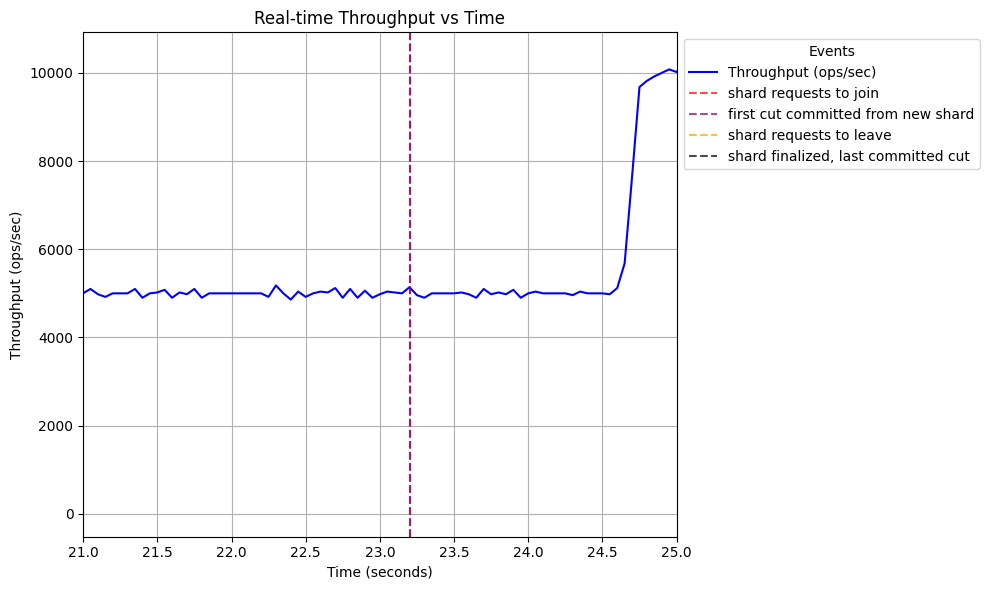

In [7]:
import re
import matplotlib.pyplot as plt
from datetime import datetime

# File path
log_file = "../results/reconfig_1000/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

# Data storage
timestamps = []
tput_values = []
shard_added = [] # when did the shards send their first cut to the OL
first_cut_committed = [] # when did the first cut get committed
shard_leave_request = [] 
shard_finalized = []
replica_2_added = []
replica_3_added = []
replica_2_committed = []
replica_3_committed = []

# Parse the log file
with open(log_file, "r") as f:
    for line in f:
        # Extract real-time throughput
        tput_match = re.search(tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(datetime.strptime(timestamp_match.group(1), "%H:%M:%S.%f"))
        
        # Extract events for annotation
        if replica_2_added == [] and "Replica 2 added" in line:
            replica_2_added.append(timestamp_match.group(1))

        if replica_3_added == [] and "Replica 3 added" in line:
            replica_3_added.append(timestamp_match.group(1))

        if replica_2_committed == [] and "cut:<key:2" in line:
            replica_2_committed.append(timestamp_match.group(1))
        
        if replica_3_committed == [] and "cut:<key:3" in line:
            replica_3_committed.append(timestamp_match.group(1))
        
        if shard_finalized == [] and "finalizeShards:<shardIDs:1 >" in line:
            shard_finalized.append(timestamp_match.group(1))

        if shard_leave_request == [] and "Shard 1 to be finalized" in line:
            shard_leave_request.append(timestamp_match.group(1))

shard_added.append(max(replica_2_added[0], replica_3_added[0]))
first_cut_committed.append(max(replica_2_committed[0], replica_3_committed[0]))

# Convert timestamps to seconds since the start
start_time = timestamps[0]
time_in_seconds = [(ts - start_time).total_seconds() for ts in timestamps]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_in_seconds, tput_values, label="Throughput (ops/sec)", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Throughput (ops/sec)")
plt.title("Real-time Throughput vs Time")
plt.grid()

# Event times
shard_join_request = (datetime.strptime(shard_added[0], "%H:%M:%S.%f") - start_time).total_seconds()
first_cut_committed_time = (datetime.strptime(first_cut_committed[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_leave_request_time = (datetime.strptime(shard_leave_request[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_finalized_time = (datetime.strptime(shard_finalized[0], "%H:%M:%S.%f") - start_time).total_seconds()

# Add vertical lines for events
plt.axvline(shard_join_request, color="red", linestyle="--", alpha=0.7, label="shard requests to join")
plt.axvline(first_cut_committed_time, color="purple", linestyle="--", alpha=0.7, label="first cut committed from new shard")
plt.axvline(shard_leave_request_time, color="orange", linestyle="--", alpha=0.7, label="shard requests to leave")
plt.axvline(shard_finalized_time, color="black", linestyle="--", alpha=0.7, label="shard finalized, last committed cut")

# Zoom in to the relevant range (adjust as needed)
plt.xlim(21, 25)
# plt.xlim(10, 65)
# plt.xlim(52, 55)

# Add legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()

# Save the plot
plt.savefig("adding_reconfig_throughput_annotated.png", dpi=600)

plt.show()
